In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
import os, sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# disabling log messages from TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# creating an end of run alarm
from IPython.display import Audio
sound_file = '/Users/dsbox/Documents/Flatiron/phase_5/WAILERLP.wav'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

# import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

from keras import layers, models, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

time: 4.93 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.45 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 618 µs


### Database ERD

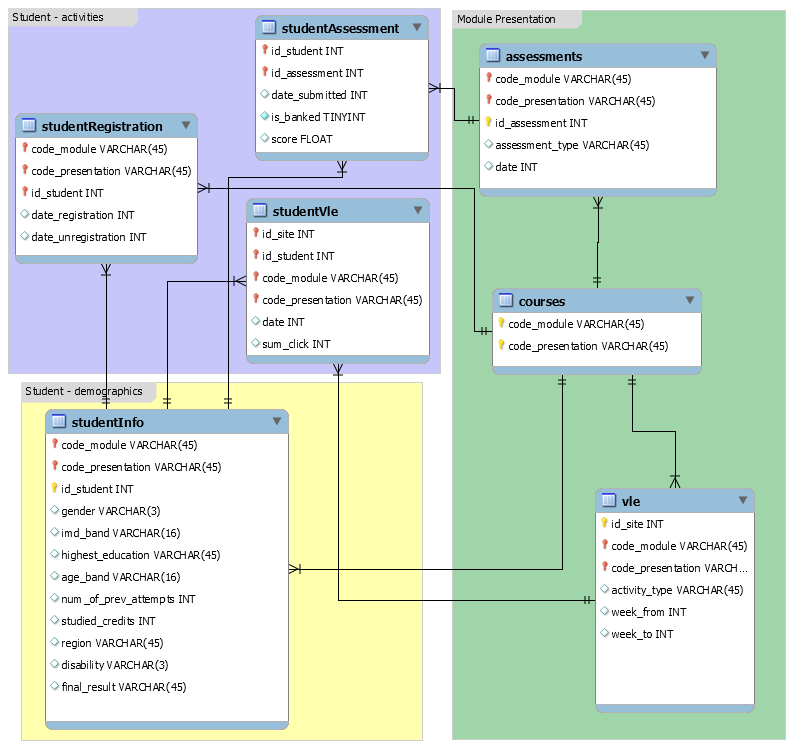

time: 3.74 ms


In [5]:
db.erd

## Preprocessing and Harness Objects

In [6]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))
sm = SMOTE(random_state=2021)

time: 1.56 ms


In [7]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 3.03 ms


In [8]:
path = os.path.join(gparent, 'data/processed/q2.csv')
df = pd.read_csv(path)

time: 63.4 ms


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24770 entries, 0 to 24769
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   score                       22987 non-null  float64
 1   gender                      23010 non-null  object 
 2   region                      23010 non-null  object 
 3   highest_education           23010 non-null  object 
 4   imd_band                    22098 non-null  object 
 5   age_band                    23010 non-null  object 
 6   num_of_prev_attempts        23010 non-null  float64
 7   studied_credits             23010 non-null  float64
 8   disability                  23010 non-null  object 
 9   final_result                23010 non-null  object 
 10  course_length               23010 non-null  float64
 11  date_shift                  23010 non-null  float64
 12  row_id                      24770 non-null  object 
 13  target                      230

In [10]:
df.describe()

,score,num_of_prev_attempts,studied_credits,course_length,date_shift,target,weighted_ave,mean_score,median_score,module_presentation_length,id_site,date,sum_click,click_sum,num_activities,date_registration,date_unregistration
count,22987.000000,23010.000000,23010.000000,23010.000000,23010.000000,23010.000000,23005.000000,23005.000000,23005.000000,23010.000000,23010.000000,23010.000000,23010.000000,23010.000000,23010.000000,24770.000000,2255.000000
mean,73.424414,0.148501,75.314429,239.678444,49.912777,0.337288,86.569463,75.205800,75.286633,256.093742,743788.946588,-8.844894,2.734376,792.284963,223.233203,-65.488736,170.795565
std,21.030561,0.457578,37.107281,5.641752,12.924222,0.472794,56.620659,15.718019,16.039881,13.154489,125362.892973,10.814963,5.733762,892.486517,191.999609,47.117116,33.475645
min,0.000000,0.000000,30.000000,234.000000,14.000000,0.000000,0.000000,0.000000,0.000000,234.000000,526721.000000,-25.000000,1.000000,1.000000,1.000000,-311.000000,121.000000
25%,65.000000,0.000000,60.000000,240.000000,43.000000,0.000000,34.800000,67.750000,67.500000,241.000000,673523.000000,-17.000000,1.000000,241.000000,87.000000,-94.000000,144.000000
50%,77.000000,0.000000,60.000000,240.000000,46.000000,0.000000,84.400000,78.666667,78.500000,262.000000,768351.000000,-10.000000,1.000000,506.000000,168.000000,-52.000000,165.000000
75%,88.000000,0.000000,90.000000,241.000000,56.000000,1.000000,129.120000,86.333333,87.000000,268.000000,832760.000000,-4.000000,3.000000,1011.000000,301.000000,-29.000000,198.000000
max,100.000000,6.000000,630.000000,268.000000,119.000000,1.000000,266.260000,100.000000,100.000000,269.000000,913740.000000,94.000000,511.000000,12940.000000,1577.000000,167.000000,444.000000


time: 57.9 ms


In [11]:
f.col_pop(df, 'target')
f.col_pop(df, 'row_id', 1)
conversions = ['target', 'studied_credits']
df[conversions] = df[conversions].apply(pd.to_numeric)
# adding course_load column
df['course_load'] = pd.qcut(df.studied_credits, q=4,\
                                labels=['Light', 'Medium', 'Heavy'],\
                                duplicates='drop')

time: 23.5 ms


In [12]:
df.shape

(24770, 26)

time: 2.52 ms


In [13]:
df['imd_band'] = df['imd_band'].replace(['10-20'], '10-20%')
# renaming values
df['disability'] = df['disability'].replace(['Y', 'N'], ['Yes', 'No'])
df['gender'] = df['gender'].replace(['M', 'F'], ['Male', 'Female'])

time: 9.63 ms


In [14]:
df.shape

(24770, 26)

time: 2.42 ms


In [15]:
Q1 = df.studied_credits.quantile(0.25)
Q3 = df.studied_credits.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df.studied_credits < (Q1 - 1.5 * IQR))\
                        |(df.studied_credits > (Q3 + 1.5 * IQR)))].copy()
           
Q1 = df.weighted_ave.quantile(0.25)
Q3 = df.weighted_ave.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df.weighted_ave < (Q1 - 1.5 * IQR))\
                        |(df.weighted_ave > (Q3 + 1.5 * IQR)))].copy()

time: 12.5 ms


In [16]:
df.shape

(23659, 26)

time: 1.83 ms


In [17]:
drops = ['row_id', 'studied_credits', 'final_result',
         'id_site' ,'date', 'sum_click', 
         'score','course_length', 'date_shift', 'date_registration',
         'date_unregistration', 'module_presentation_length']

time: 1.06 ms


In [18]:
df = df.drop(drops, axis=1)

time: 3.3 ms


In [19]:
df.shape

(23659, 14)

time: 2.16 ms


In [20]:
df = df.dropna()

time: 8.97 ms


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21028 entries, 1 to 24769
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                21028 non-null  float64 
 1   gender                21028 non-null  object  
 2   region                21028 non-null  object  
 3   highest_education     21028 non-null  object  
 4   imd_band              21028 non-null  object  
 5   age_band              21028 non-null  object  
 6   num_of_prev_attempts  21028 non-null  float64 
 7   disability            21028 non-null  object  
 8   weighted_ave          21028 non-null  float64 
 9   mean_score            21028 non-null  float64 
 10  median_score          21028 non-null  float64 
 11  click_sum             21028 non-null  float64 
 12  num_activities        21028 non-null  float64 
 13  course_load           21028 non-null  category
dtypes: category(1), float64(7), object(6)
memory usage: 2.

In [22]:
df.target.value_counts(normalize=True)

0.0    0.661737
1.0    0.338263
Name: target, dtype: float64

time: 3.66 ms


## Creating Holdout Data

In [23]:
# splitting data & target
X, y = f.X_y(df)

time: 2.4 ms


In [24]:
# splitting traing and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 11.6 ms


## Creating Training Data

In [25]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 8.04 ms


# SS Test

## KNeighborsClassifier

In [26]:
KNN = KNeighborsClassifier(n_jobs=-1)

time: 869 µs


In [27]:
knn_ss = make_pipeline(preprocessing_ss, KNN)

time: 947 µs


### Fitting Model

In [28]:
knn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506ad00>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506a670>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

time: 38.7 ms


In [29]:
# f.pickle_model(knn_ss, 'knn_ss')

time: 582 µs


### Cross Val Scores

In [30]:
# checking cross val scores
modeling.report(knn_ss, X_train, y_train, 'knn_ss',\
                'KNN SS()')

knn_ss has an average Accuracy of 0.7086575678346698
knn_ss has an average F1 of 0.525537344693188
knn_ss has an average Recall of 0.47713264669163546
knn_ss has an average Precision of 0.5851637620772319
time: 3.94 s


### Test Data Confusion Matrix

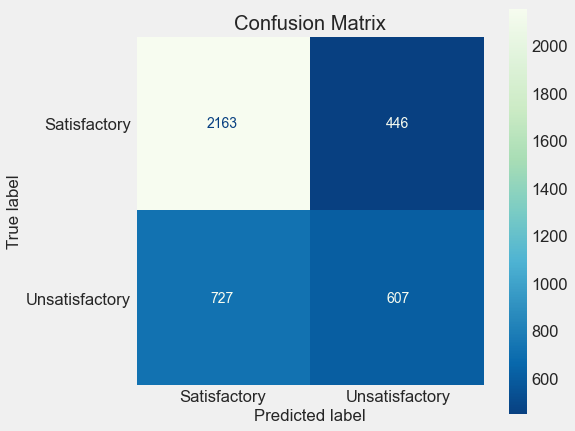

,Accuracy,F1,Recall,Precision
0,0.702511,0.508588,0.455022,0.576448


time: 8.36 s


In [31]:
f.confusion_report(knn_ss, X_test, y_test)

## Logistic Regression Classifier

In [32]:
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021, verbose=0)

time: 768 µs


In [33]:
logreg_ss = make_pipeline(preprocessing_ss, LR)

time: 1.15 ms


### Fitting Model

In [34]:
logreg_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506ad00>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506a670>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1,
                                    random_state=2021))])

time: 3.92 s


In [35]:
# f.pickle_model(logreg_ss, 'logreg_ss')

time: 1.56 ms


### Cross Val Scores

In [36]:
# checking cross val scores
modeling.report(logreg_ss, X_train, y_train, 'logreg_ss',\
                'LogReg SS()')

logreg_ss has an average Accuracy of 0.7266653203683615
logreg_ss has an average F1 of 0.5107057372629823
logreg_ss has an average Recall of 0.4218985642946317
logreg_ss has an average Precision of 0.647493541315717
time: 4.5 s


### Test Data Confusion Matrix

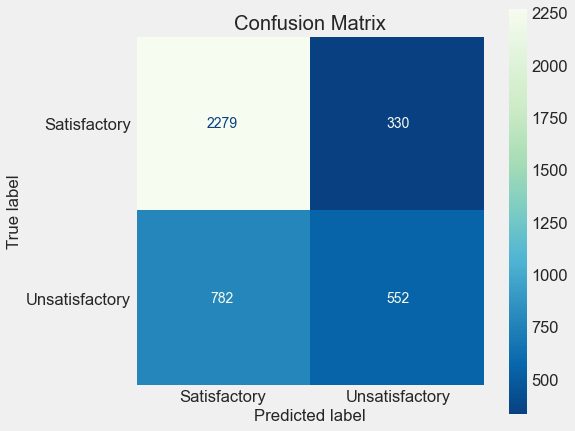

,Accuracy,F1,Recall,Precision
0,0.717981,0.498195,0.413793,0.62585


time: 197 ms


In [37]:
f.confusion_report(logreg_ss, X_test, y_test)

## Support Vector Machine

In [38]:
SVC = SVC()

time: 687 µs


In [39]:
svc_ss = make_pipeline(preprocessing_ss, SVC)

time: 1.16 ms


### Fitting Model

In [40]:
svc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506ad00>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506a670>)])),
                ('svc', SVC())])

time: 5.83 s


In [41]:
# f.pickle_model(svc_ss, 'svc_ss')

time: 858 µs


### Cross Val Scores

In [42]:
# checking cross val scores
modeling.report(svc_ss, X_train, y_train, 'svc_ss',\
                'Support Vector CLF SS()')

svc_ss has an average Accuracy of 0.7414610434288431
svc_ss has an average F1 of 0.5334638171076105
svc_ss has an average Recall of 0.437145443196005
svc_ss has an average Precision of 0.6846747992345078
time: 21.7 s


### Test Data Confusion Matrix

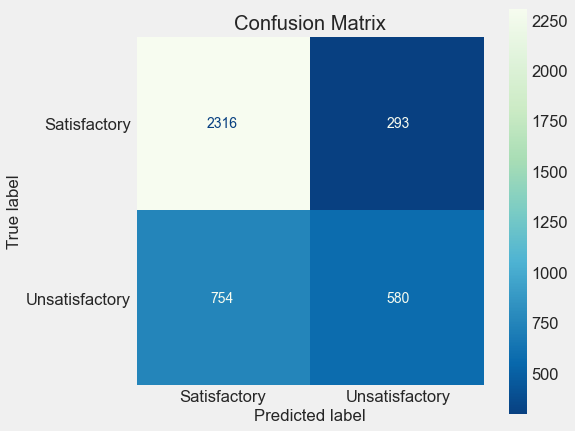

,Accuracy,F1,Recall,Precision
0,0.734466,0.5256,0.434783,0.664376


time: 6.22 s


In [43]:
f.confusion_report(svc_ss, X_test, y_test)

## Linear Support Vector Machine

In [44]:
LSVC = LinearSVC()

time: 850 µs


In [45]:
lsvc_ss = make_pipeline(preprocessing_ss, LSVC)

time: 969 µs


### Fitting Model

In [46]:
lsvc_ss.fit(X_train, y_train)

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506ad00>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506a670>)])),
                ('linearsvc', LinearSVC())])

time: 667 ms


In [47]:
# f.pickle_model(lsvc_ss, 'lsvc_ss')

time: 794 µs


### Cross Val Scores

In [48]:
# checking cross val scores
modeling.report(lsvc_ss, X_train, y_train, 'lsvc_ss',\
                'Linear SVC SS()')

/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


lsvc_ss has an average Accuracy of 0.7250591984044579
lsvc_ss has an average F1 of 0.49930158339530656
lsvc_ss has an average Recall of 0.4054010611735331
lsvc_ss has an average Precision of 0.6502858169520338
time: 2.66 s


/Users/dsbox/opt/anaconda3/envs/oo/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### Test Data Confusion Matrix

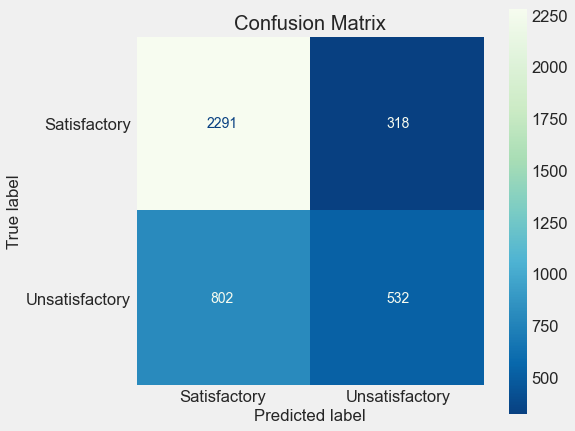

,Accuracy,F1,Recall,Precision
0,0.715952,0.487179,0.398801,0.625882


time: 206 ms


In [49]:
f.confusion_report(lsvc_ss, X_test, y_test)

## Decision Tree

In [50]:
DT = DecisionTreeClassifier(random_state=2021)

time: 995 µs


In [51]:
dt_ss = make_pipeline(preprocessing_ss, DT)

time: 955 µs


### Fitting Model

In [52]:
dt_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506ad00>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506a670>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

time: 557 ms


In [53]:
# f.pickle_model(dt_ss, 'dt_ss')

time: 568 µs


### Cross Val Scores

In [54]:
# checking cross val scores
modeling.report(dt_ss, X_train, y_train, 'dt_ss',\
                'Decision Tree CLF SS()')

dt_ss has an average Accuracy of 0.6755151824919267
dt_ss has an average F1 of 0.5250075462832369
dt_ss has an average Recall of 0.5301186017478152
dt_ss has an average Precision of 0.5200175697817012
time: 1.79 s


### Test Data Confusion Matrix

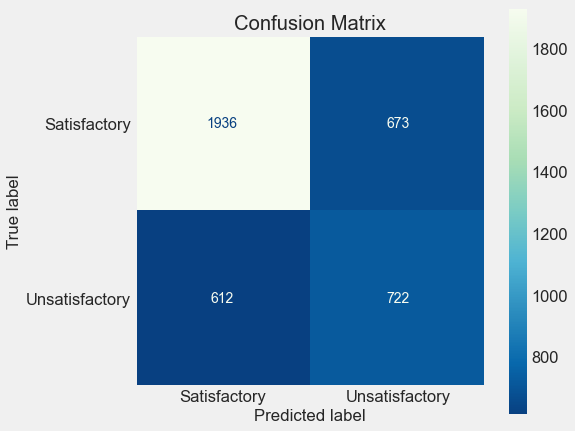

,Accuracy,F1,Recall,Precision
0,0.674106,0.529132,0.541229,0.517563


time: 189 ms


In [55]:
f.confusion_report(dt_ss, X_test, y_test)

## Bagging Classifier

In [56]:
BCLF = BaggingClassifier(base_estimator=DT, random_state=2021)

time: 861 µs


In [57]:
bclf_ss = make_pipeline(preprocessing_ss, BCLF)

time: 944 µs


### Fitting Model

In [58]:
bclf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506ad00>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506a670>)])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                   random_state=2021))])

time: 3.15 s


In [59]:
# f.pickle_model(bclf_ss, 'bclf_ss')

time: 605 µs


### Cross Val Scores

In [60]:
# checking cross val scores
modeling.report(bclf_ss, X_train, y_train, 'bclf_ss',\
                'Bagging CLF SS()')

bclf_ss has an average Accuracy of 0.7401082280867611
bclf_ss has an average F1 of 0.5507376650427313
bclf_ss has an average Recall of 0.4708826466916355
bclf_ss has an average Precision of 0.6634070066096129
time: 11.5 s


### Test Data Confusion Matrix

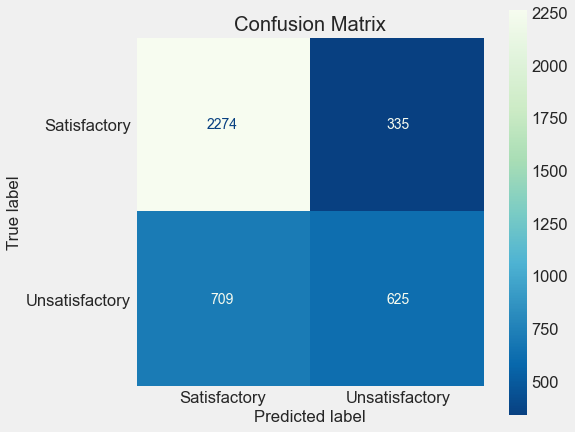

,Accuracy,F1,Recall,Precision
0,0.735227,0.5449,0.468516,0.651042


time: 267 ms


In [61]:
f.confusion_report(bclf_ss, X_test, y_test)

## Random Forest Classifier

In [62]:
RF = RandomForestClassifier(n_jobs=-1, random_state=2021)

time: 843 µs


In [63]:
rf_ss = make_pipeline(preprocessing_ss, RF)

time: 956 µs


### Fitting Model

In [64]:
rf_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506ad00>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506a670>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=2021))])

time: 2.03 s


In [65]:
# f.pickle_model(rf_ss, 'rf_ss')

time: 684 µs


### Cross Val Scores

In [66]:
# checking cross val scores
modeling.report(rf_ss, X_train, y_train, 'rf_ss',\
                'Random Forest SS()')

rf_ss has an average Accuracy of 0.7534665692089664
rf_ss has an average F1 of 0.5789078635944983
rf_ss has an average Recall of 0.5011276529338327
rf_ss has an average Precision of 0.6856205010066294
time: 10.4 s


### Test Data Confusion Matrix

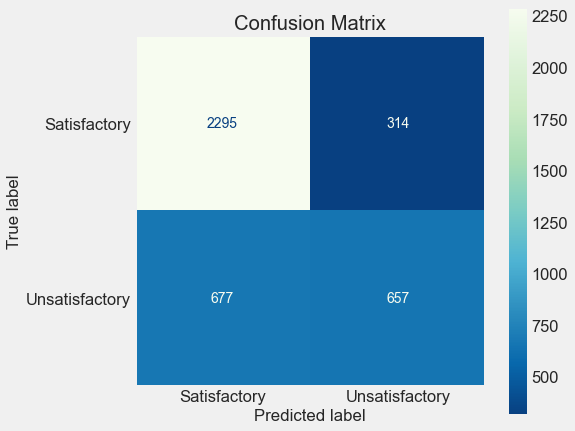

,Accuracy,F1,Recall,Precision
0,0.748669,0.570065,0.492504,0.676622


time: 438 ms


In [67]:
f.confusion_report(rf_ss, X_test, y_test)

## AdaBoost

In [68]:
ADA = AdaBoostClassifier(base_estimator=DT, random_state=2021)

time: 847 µs


In [69]:
ada_ss = make_pipeline(preprocessing_ss, ADA)

time: 931 µs


### Fitting Model

In [70]:
ada_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506ad00>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506a670>)])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=2021),
                                    random_state=2021))])

time: 633 ms


In [71]:
# f.pickle_model(ada_ss, 'ada_ss')

time: 1.11 ms


### Cross Val Scores

In [72]:
# checking cross val scores
modeling.report(ada_ss, X_train, y_train, 'ada_ss',\
                'AdaBoost SS()')

ada_ss has an average Accuracy of 0.6752624834914639
ada_ss has an average F1 of 0.523534246956668
ada_ss has an average Recall of 0.5273701622971286
ada_ss has an average Precision of 0.5199162371904212
time: 1.95 s


### Test Data Confusion Matrix

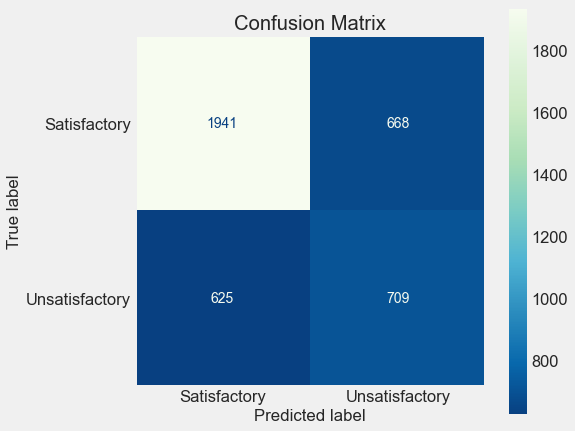

,Accuracy,F1,Recall,Precision
0,0.672077,0.523054,0.531484,0.514887


time: 228 ms


In [73]:
f.confusion_report(ada_ss, X_test, y_test)

## XGBoost

In [74]:
XGB = XGBClassifier(use_label_encoder=False)

time: 829 µs


In [75]:
xgb_ss = make_pipeline(preprocessing_ss, XGB)

time: 970 µs


### Fitting Model

In [76]:
%%capture --no-display
xgb_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506ad00>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506a670>)])),
                ('xgbclassifier',
                 XGBClassifie...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estima

time: 751 ms


In [77]:
# f.pickle_model(xgb_ss, 'xgb_ss')

time: 862 µs


### Cross Val Scores

In [78]:
%%capture --no-display
# checking cross val scores
modeling.report(xgb_ss, X_train, y_train, 'xgb_ss',\
                'XGBoost SS()')

time: 3.44 s


### Test Data Confusion Matrix

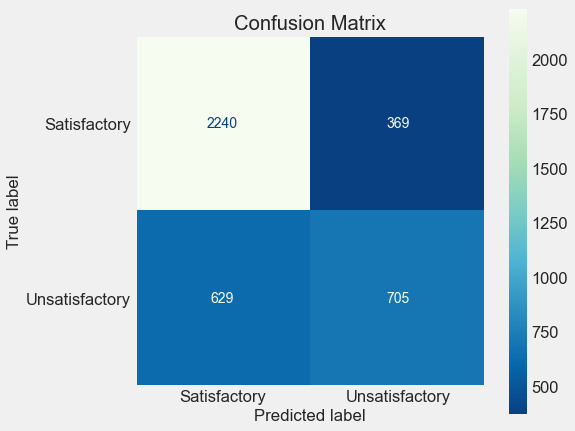

,Accuracy,F1,Recall,Precision
0,0.746893,0.585548,0.528486,0.656425


time: 325 ms


In [79]:
%%capture --no-display
f.confusion_report(xgb_ss, X_test, y_test)

## Model Summary 8

In [80]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,ada_ss,0.675262,0.523534,0.527370,0.519916,1.951531,AdaBoost SS()
1,dt_ss,0.675515,0.525008,0.530119,0.520018,1.785040,Decision Tree CLF SS()
2,knn_ss,0.708658,0.525537,0.477133,0.585164,3.934364,KNN SS()
3,lsvc_ss,0.725059,0.499302,0.405401,0.650286,2.652513,Linear SVC SS()
4,logreg_ss,0.726665,0.510706,0.421899,0.647494,4.494105,LogReg SS()
5,bclf_ss,0.740108,0.550738,0.470883,0.663407,11.500210,Bagging CLF SS()
6,svc_ss,0.741461,0.533464,0.437145,0.684675,21.672941,Support Vector CLF SS()
8,xgb_ss,0.751775,0.590047,0.528119,0.668515,3.438714,XGBoost SS()
7,rf_ss,0.753467,0.578908,0.501128,0.685621,10.422375,Random Forest SS()


time: 9.06 ms


## Voting Classifier
Using the top three model in a voting classifier.

In [81]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf',clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.12 ms


In [82]:
vc_ss = make_pipeline(preprocessing_ss, VC)

time: 906 µs


### Fitting Model

In [83]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506ad00>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506a670>)])),
                ('votingclassifier',
                 VotingCla...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
   

time: 5.67 s


In [84]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 756 µs


### Cross Val Scores

In [85]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()')

time: 20.9 s


### Test Data Confusion Matrix

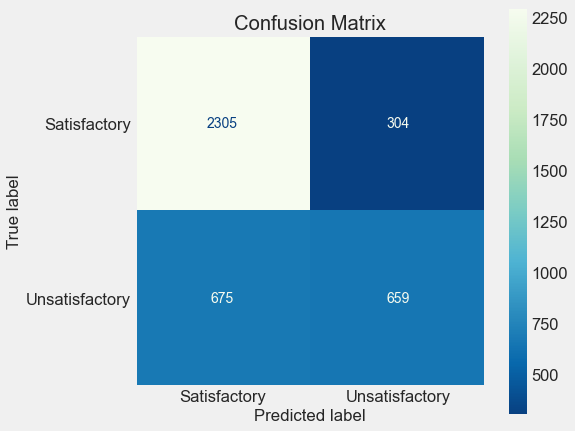

,Accuracy,F1,Recall,Precision
0,0.751712,0.573792,0.494003,0.68432


time: 819 ms


In [86]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary

In [87]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,ada_ss,0.675262,0.523534,0.527370,0.519916,1.951531,AdaBoost SS()
1,dt_ss,0.675515,0.525008,0.530119,0.520018,1.785040,Decision Tree CLF SS()
2,knn_ss,0.708658,0.525537,0.477133,0.585164,3.934364,KNN SS()
3,lsvc_ss,0.725059,0.499302,0.405401,0.650286,2.652513,Linear SVC SS()
4,logreg_ss,0.726665,0.510706,0.421899,0.647494,4.494105,LogReg SS()
5,bclf_ss,0.740108,0.550738,0.470883,0.663407,11.500210,Bagging CLF SS()
6,svc_ss,0.741461,0.533464,0.437145,0.684675,21.672941,Support Vector CLF SS()
7,xgb_ss,0.751775,0.590047,0.528119,0.668515,3.438714,XGBoost SS()
8,rf_ss,0.753467,0.578908,0.501128,0.685621,10.422375,Random Forest SS()
9,vc_ss,0.757355,0.583903,0.503376,0.695394,20.923447,Voting CLF SS()


time: 9.8 ms


## Neural Network

### Create Model

In [88]:
def create_model():
    # building model
    model = Sequential()
    model.add(Dense(64, input_dim=41, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

time: 1.45 ms


In [89]:
NN = KerasClassifier(build_fn=create_model,
                     epochs=10,
                     batch_size=32,
                     verbose=0)

time: 1.21 ms


### Pipeline

In [90]:
nn_ss = make_pipeline(preprocessing_ss, NN)

time: 1.1 ms


### Fitting Models

In [91]:
%%capture --no-display
nn_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506ad00>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506a670>)])),
                ('kerasclassifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x17db514f0>)])

time: 4.54 s


In [92]:
# f.pickle_model(nn_ss, 'nn_ss')

time: 768 µs


### Cross Val Scores

In [93]:
%%capture --no-display
modeling.report(nn_ss, X_train, y_train, 'nn_ss',\
                'Neural Net SS()')

time: 18.2 s


### Test Data Confusion Matrix

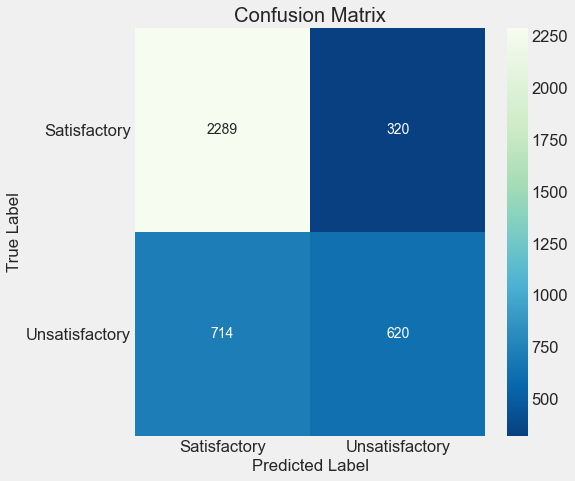

,Accuracy,F1,Recall,Precision
0,0.737763,0.545295,0.464768,0.659574


time: 607 ms


In [94]:
%%capture --no-display
f.confusion_report_nn(nn_ss, X_test, y_test)

## Model Summary 10

In [95]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,ada_ss,0.675262,0.523534,0.527370,0.519916,1.951531,AdaBoost SS()
1,dt_ss,0.675515,0.525008,0.530119,0.520018,1.785040,Decision Tree CLF SS()
2,knn_ss,0.708658,0.525537,0.477133,0.585164,3.934364,KNN SS()
3,lsvc_ss,0.725059,0.499302,0.405401,0.650286,2.652513,Linear SVC SS()
4,logreg_ss,0.726665,0.510706,0.421899,0.647494,4.494105,LogReg SS()
10,nn_ss,0.732838,0.561383,0.506149,0.633116,18.183487,Neural Net SS()
5,bclf_ss,0.740108,0.550738,0.470883,0.663407,11.500210,Bagging CLF SS()
6,svc_ss,0.741461,0.533464,0.437145,0.684675,21.672941,Support Vector CLF SS()
7,xgb_ss,0.751775,0.590047,0.528119,0.668515,3.438714,XGBoost SS()
8,rf_ss,0.753467,0.578908,0.501128,0.685621,10.422375,Random Forest SS()


time: 11.4 ms


In [96]:
clf1 = BCLF
clf2 = RF
clf3 = XGB

estimators = [('bclf',clf1), ('rf', clf2), ('xgb', clf3)]

VC = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

time: 1.25 ms


In [97]:
vc_ss = make_sm_pipeline(preprocessing_ss, sm, VC)

time: 1.02 ms


### Fitting Model

In [98]:
%%capture --no-display
vc_ss.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506ad00>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10506a670>)])),
                ('smote', SMOTE(random_state=2...
                                                             interaction_constraints='',
                                                             learning_rate=0.300000012,
                                                             max_delta_step=0,
                                                             max_depth=6,
                    

time: 9.54 s


In [99]:
# f.pickle_model(vc_ss, 'vc_ss')

time: 623 µs


### Cross Val Scores

In [100]:
%%capture --no-display
# checking cross val scores
modeling.report(vc_ss, X_train, y_train, 'vc_ss',\
                'Voting CLF SS()/SMOTE')

time: 35.1 s


### Test Data Confusion Matrix

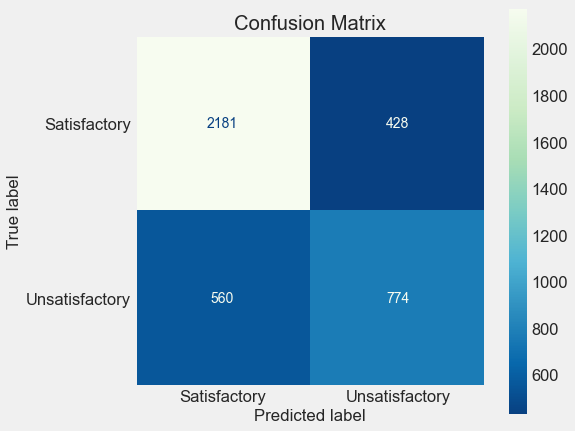

,Accuracy,F1,Recall,Precision
0,0.749429,0.61041,0.58021,0.643927


time: 815 ms


In [101]:
%%capture --no-display
f.confusion_report(vc_ss, X_test, y_test)

## Model Summary 9

In [102]:
modeling.history

,Name,Accuracy,F1,Recall,Precision,CV_Time(sec),Notes
0,ada_ss,0.675262,0.523534,0.527370,0.519916,1.951531,AdaBoost SS()
1,dt_ss,0.675515,0.525008,0.530119,0.520018,1.785040,Decision Tree CLF SS()
2,knn_ss,0.708658,0.525537,0.477133,0.585164,3.934364,KNN SS()
3,lsvc_ss,0.725059,0.499302,0.405401,0.650286,2.652513,Linear SVC SS()
4,logreg_ss,0.726665,0.510706,0.421899,0.647494,4.494105,LogReg SS()
5,nn_ss,0.732838,0.561383,0.506149,0.633116,18.183487,Neural Net SS()
6,bclf_ss,0.740108,0.550738,0.470883,0.663407,11.500210,Bagging CLF SS()
7,svc_ss,0.741461,0.533464,0.437145,0.684675,21.672941,Support Vector CLF SS()
8,xgb_ss,0.751775,0.590047,0.528119,0.668515,3.438714,XGBoost SS()
9,rf_ss,0.753467,0.578908,0.501128,0.685621,10.422375,Random Forest SS()


time: 11.6 ms


In [103]:
Audio(sound_file, autoplay=True)

time: 192 ms
[16:18:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to resto